In [12]:
!pip install dask
!pip install numpy
!pip install pandas
!pip install pyarrow


 ***** Summary before filtering missing values ***** 

            Severity           Start_Time             End_Time  Distance(mi)  \
count   7.100352e+06              7100352              7100352  7.100352e+06   
unique           NaN              5618143              6169906           NaN   
top              NaN  2021-01-26 16:16:13  2021-11-22 08:00:00           NaN   
freq             NaN                  225                  112           NaN   
mean    2.202366e+00                  NaN                  NaN  5.701286e-01   
std     4.802905e-01                  NaN                  NaN  1.767549e+00   
min     1.000000e+00                  NaN                  NaN  0.000000e+00   
25%     2.000000e+00                  NaN                  NaN  0.000000e+00   
50%     2.000000e+00                  NaN                  NaN  3.800000e-02   
75%     2.000000e+00                  NaN                  NaN  4.800000e-01   
max     4.000000e+00                  NaN                  NaN  

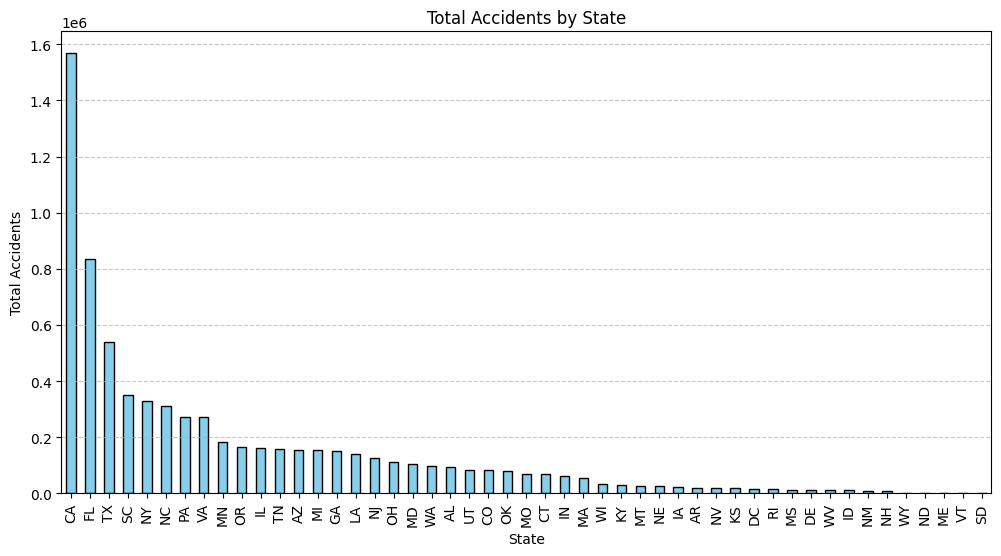

Dats saved according to state.
 


In [33]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Define file path and chunk size
file_path = r"..\data\US_Accidents_March23.csv"
chunk_size = 100000  # Adjust based on available memory

def read_large_csv(file_path, chunk_size):
    """Reads a large CSV file in chunks and returns a generator of chunks."""
    return pd.read_csv(file_path, chunksize=chunk_size, low_memory=False)

def filter_required_columns(df):
    """Select only required columns from the dataset."""
    required_columns = [
        "Severity", "Start_Time", "End_Time", "Distance(mi)", "Description", "City", 
        "County", "State", "Zipcode", "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", 
        "Visibility(mi)", "Wind_Speed(mph)", "Weather_Condition", "Crossing", "Junction", 
        "Traffic_Signal", "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight"
    ]
    return df[required_columns]

def drop_missing_data(df, threshold=0.05):
    """Drops rows with more than 5% missing data."""
    missing_limit = threshold * len(df.columns)  # Calculate max allowable missing values per row
    return df[df.isnull().sum(axis=1) <= missing_limit]

def process_large_csv(file_path, chunk_size=100000):
    """Processes the large CSV file and returns the cleaned DataFrame."""
    df_combined = pd.DataFrame()  # Initialize empty DataFrame

    for chunk in read_large_csv(file_path, chunk_size):
        chunk_filtered = filter_required_columns(chunk)  # Select relevant columns
        chunk_filtered = drop_missing_data(chunk_filtered)  # Drop rows with too much missing data
        df_combined = pd.concat([df_combined, chunk_filtered], ignore_index=True)  # Append chunk

    return df_combined

def analyze_and_plot_states(df):
    """Analyzes the state-wise accident count and plots a histogram."""
    state_counts = df["State"].value_counts()
    
    # Print number of unique states
    print(f"\nNumber of unique states: {state_counts.count()}")

    # Print accident count by state
    print("\n ***** Accident count by state *****")
    print(state_counts)

    # Plot histogram for state vs accident count
    plt.figure(figsize=(12, 6))
    state_counts.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.xlabel("State")
    plt.ylabel("Total Accidents")
    plt.title("Total Accidents by State")
    plt.xticks(rotation=90)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def split_and_save_by_state(df, output_dir=r"..\data\state_wise_data"):
    """Splits data by state and saves it into separate CSV files."""
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

    for state, state_df in df.groupby("State"):
        state_file = os.path.join(output_dir, f"{state}.csv")
        state_df.to_csv(state_file, index=False)
    print(f"Dats saved according to state.\n ")

# Main execution
df_cleaned = process_large_csv(file_path, chunk_size)

# Print summary before filtering missing values
print("\n ***** Summary before filtering missing values ***** \n")
print(df_cleaned.describe(include="all"))

# Print summary after filtering missing values
print("\n ***** Summary after filtering missing values ***** \n")
df_cleaned = drop_missing_data(df_cleaned)
print(df_cleaned.describe(include="all"))
print("\n ***** info of data set ***** \n")
print(f"{df_cleaned.info()}")

# Analyze and visualize accident counts by state
analyze_and_plot_states(df_cleaned)

# Save cleaned data state-wise
split_and_save_by_state(df_cleaned)
